# Math Score Prediction
For this project, I would like to predict the math score by using physics, science and statistics score.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import cufflinks as cf
cf.go_offline()
plt.style.use('seaborn-bright')

# Examine The Data

In [3]:
df = pd.read_csv('Data.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pysics      450 non-null    int64
 1   Science     450 non-null    int64
 2   Statistics  450 non-null    int64
 3   Math        450 non-null    int64
dtypes: int64(4)
memory usage: 14.2 KB


There are 450 rows and 4 columns which consists of physics, science and statistics score from various students.

## Missing and Duplicated Value

In [15]:
df.isna().sum()

Pysics        0
Science       0
Statistics    0
Math          0
dtype: int64

In [16]:
df.duplicated().sum()

1

Well there are no missing values in our data, however there are 1 duplicated value.
Since there are only one duplicated value and in training a supervised machine learning algorithm we should assume that training and testing datasets is sampled from the same disttibution, we would not delete the duplicated data.

## Statistics Summary

In [17]:
df.describe()

,Pysics,Science,Statistics,Math
count,450.000000,450.000000,450.000000,450.000000
mean,71.746667,72.662222,73.757778,74.586667
std,16.066061,14.333186,12.163017,11.476239
min,0.000000,0.000000,22.000000,22.000000
25%,66.000000,66.000000,67.000000,67.000000
50%,74.000000,74.000000,74.000000,74.000000
75%,82.000000,82.000000,83.000000,83.000000
max,99.000000,99.000000,100.000000,99.000000


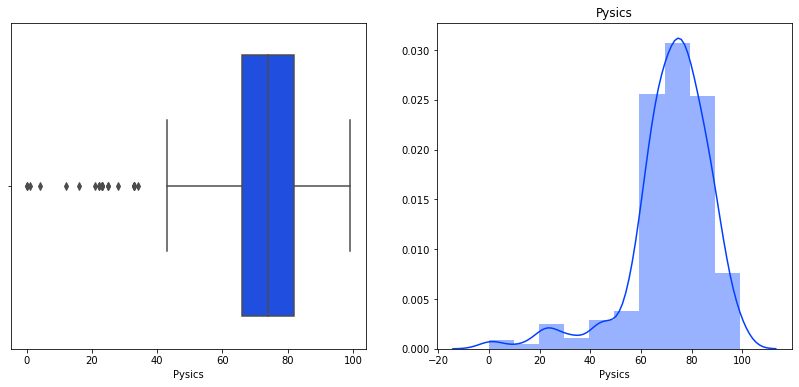

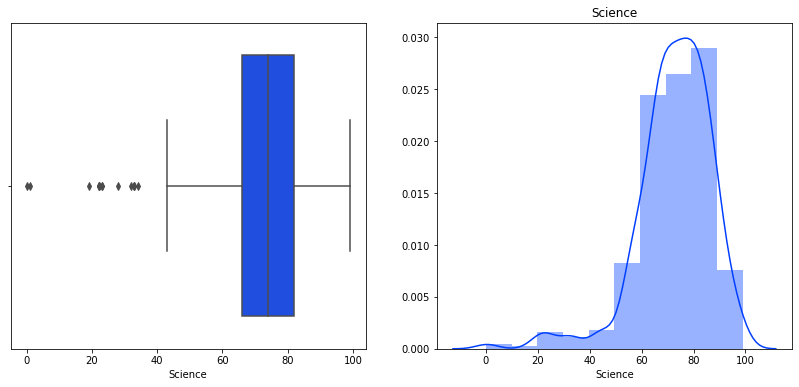

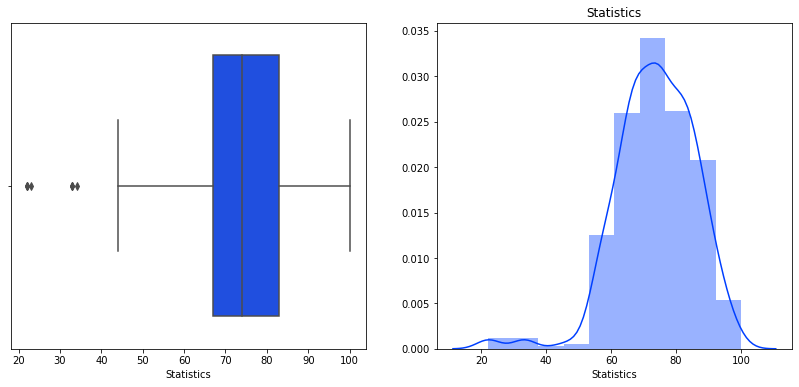

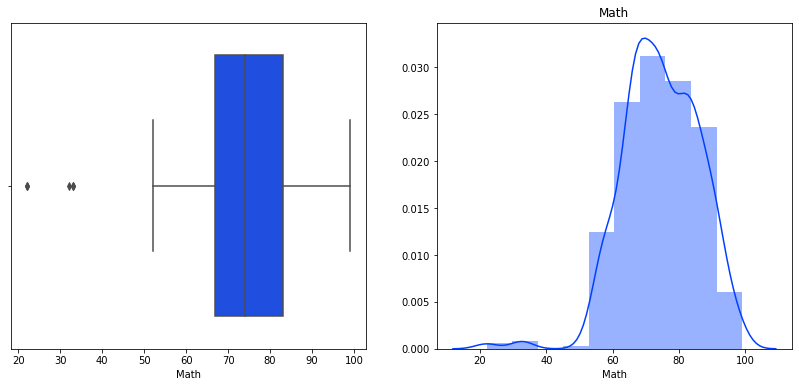

In [18]:
plots = ['Pysics', 'Science', 'Statistics','Math']
for i in plots:
    plt.figure(figsize = (14, 6))
    plt.subplot(1,2,1)
    sns.boxplot(df[i])
    plt.subplot(1,2,2)
    sns.distplot(df[i],bins= 10)    
    plt.title(i)    
    plt.show()

Even though there are visible outliers that could be seen in the boxplot, however the mean and median (50% percentile) in all subjects are not too far away, so we can assume that the data is not skewed. The data-points are still normal and won't affects much the accuracy of the model later so that we do not need any data transformations

# Exploratory Data Analysis

## Variable Correlation

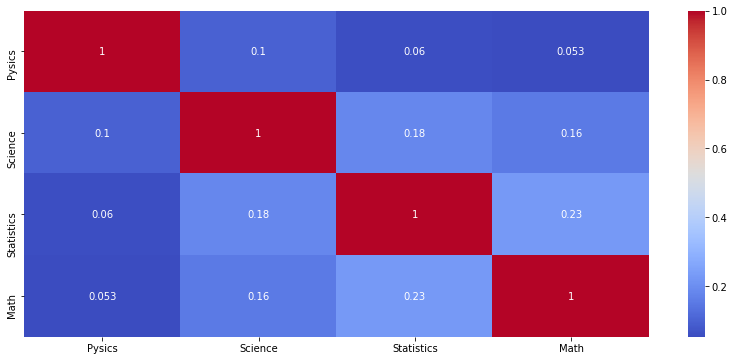

In [19]:
plt.figure(figsize = (14, 6))
sns.heatmap(df.corr(), annot=True,cmap='coolwarm')

Heatmap gives us a good general understanding about the relationship between variables in our dataset. The correlation value range from -1 and 1, where the higher the absolute value means higher degree of correlation between the variables.

From the heatmap above, we could see that the correlation between our target variable and other variables is very low (less than 0.3). It means that we can't rely on a single variable alone to predict the math score. 

## Physics Variable

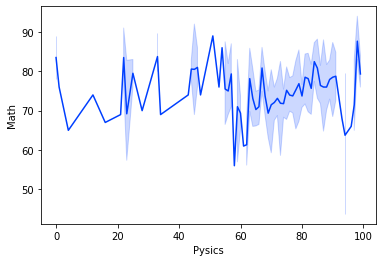

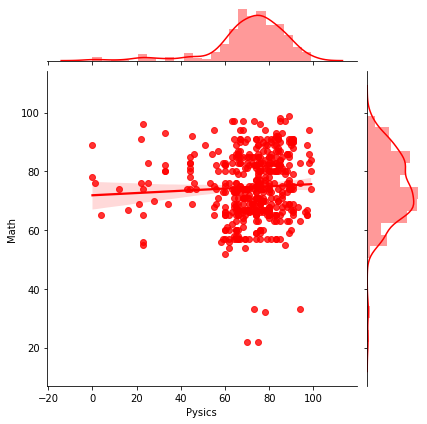

In [20]:
sns.lineplot(x=df['Pysics'],y = df['Math'])
sns.jointplot(df['Pysics'],y = df['Math'], color='red', kind='reg')

Physics and math score as can be seen from the previous heatmap is not correlate well. However, we could see that after a sudden drop of math score around physics score of 60,there are a quite steep increase of math score although there is another sudden drop on physics score of 90.

## Science Variable

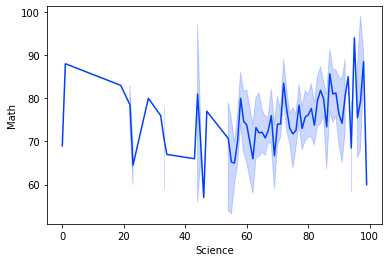

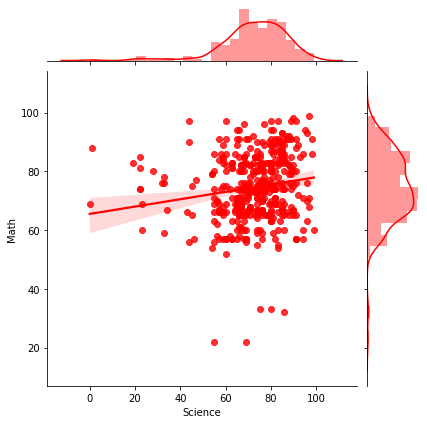

In [21]:
sns.lineplot(x=df['Science'],y = df['Math'])
sns.jointplot(df['Science'],y = df['Math'], color='red', kind='reg')

Nearly the same as the physics score, there are an increasing pattern of math score after science score of 50, although there are sudden drop just before science score of 100.

## Statistics Variable

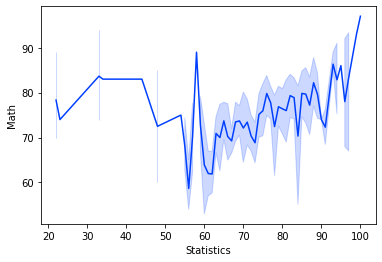

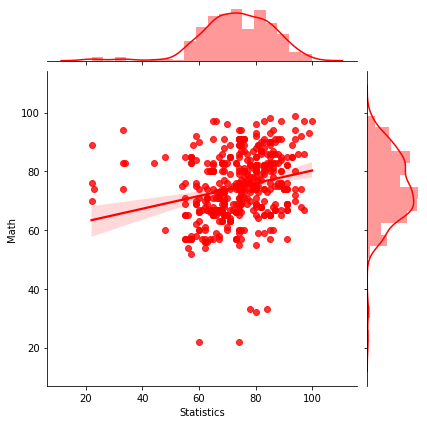

In [22]:
sns.lineplot(x=df['Statistics'],y = df['Math'])
sns.jointplot(df['Statistics'],y = df['Math'], color='red', kind='reg')

Statistics score correlate better with math rather than previous scores. After statistics score of 60, the pattern is quite consistenly increase along with the math score.

# Building a Basic Linear Regression Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import metrics

## Splitting The Data into Train and Test

In [13]:
X = df.drop('Math', axis=1)
y = df['Math']
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)

## Modeling and Predictions

In [14]:
linear=LinearRegression()
linear.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
df_coeff = pd.DataFrame(linear.coef_,X.columns, columns=['Coefficient'])
df_coeff.sort_values('Coefficient', ascending=False)

,Coefficient
Statistics,0.203832
Science,0.063483
Pysics,-0.002551


In [16]:
print(linear.intercept_)

55.24871776851327


Based on the coeffecient above, it can be interpreted that the increase of 1 score of statistics score leading to increase of math score by 0.23. 

In [17]:
predictions = linear.predict(X_test)

## Performance


In [18]:
print('MAE:',metrics.mean_absolute_error(y_test, predictions))
print('MSE:',metrics.mean_squared_error(y_test, predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 9.255221248625604
MSE: 141.81246553414576
RMSE: 11.908503916703632


In [19]:
mean_absolute_error(y_test, predictions)*100 / ((df['Math'].max()) - (df['Math'].min()))

12.019767855357928

With MAE score of 9.7, it means that error range of the model in our test dataset is 12.64%. Now, let's explore the residuals and r square:

In [21]:
r2_score(y_test,predictions)

0.07264897173774387

R squared by definition is the percentage of the total variability that is explained by the linear relationship with the predictor. Low R square in the model means there is lack of linear relationship between the predictor variables and target. As one of the limitations of regression models is that to having a strong linear relationship between the predictor and target variables, we can't use linear regression for this kind of dataset.

# Feature Engineering

Relying on physics, science and statistics score alone will not be sufficient enough to make a good model. So that, we decide to make other variables based on available variables. We'll make a variable for each subject that describe whether the student score is above the average or not. 

In [39]:
df['Physics_Pass'] = df['Pysics'].apply(lambda x: 1 if x > df['Pysics'].mean() else 0)
df['Science_Pass'] = df['Science'].apply(lambda x: 1 if x > df['Science'].mean() else 0)
df['Statistics_Pass'] = df['Statistics'].apply(lambda x: 1 if x > df['Statistics'].mean() else 0)

In [40]:
df.head()

,Pysics,Science,Statistics,Math,Physics_Pass,Science_Pass,Statistics_Pass
149,0,80,76,89,0,1,1
232,0,77,76,78,0,1,1
131,1,67,78,76,0,0,1
223,4,69,83,65,0,0,1
113,12,81,96,74,0,1,1


Let's navigate the new variables and their relationship with math score:

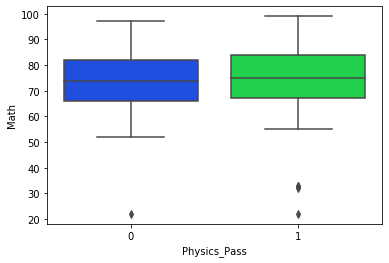

In [41]:
sns.boxplot(x=df['Physics_Pass'],y=df['Math'])

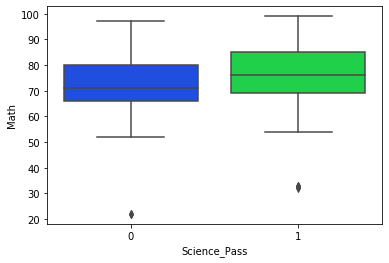

In [70]:
sns.boxplot(x=df['Science_Pass'],y=df['Math'])

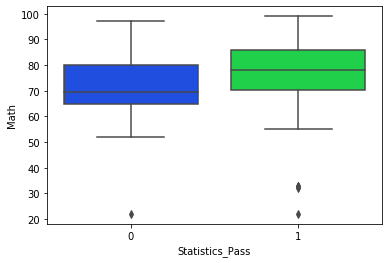

In [71]:
sns.boxplot(x=df['Statistics_Pass'],y=df['Math'])

From the boxplots above, except for the statistics there are no huge differences between the group who are above and below the average. Let's try to make another variable! This time the new variable is describing the total subjects that the student has passed or above the group average:

In [42]:
df['Total_Pass'] = df['Physics_Pass'] + df['Science_Pass'] + df['Statistics_Pass']

In [43]:
df['Total_Pass'].describe()

count    450.000000
mean       1.688889
std        0.979119
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: Total_Pass, dtype: float64

On average, the student has passed nearly 2 subjects. Let's see the relationship with math score:

In [122]:
count = df.groupby(["Total_Pass","Math"]).size().reset_index(name='Count')
fig = px.histogram(count, x='Math', y='Count',color='Total_Pass', marginal="box", title = 'Histogram Plot of Math Score in Total Pass Group', labels = {'Count':'','Math':'Math Score', 'Total_Pass':'Total Pass'},opacity=0.7,histfunc='avg')
fig.layout.template = 'plotly_dark'
fig.show()

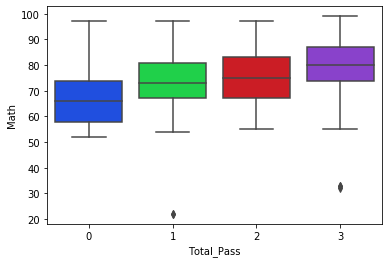

In [74]:
sns.boxplot(x=df['Total_Pass'],y=df['Math'])

Our new variable is describing well the relationship between the number of subjects that the student has passed and math score. We could see that the math score tend to increase when they pass more subjects. This variable would be important for our machine learning model later on.

# Machine Learning

In this section, we'll do modeling by using k-nearest neighbors (k-NN) and two ensemble methods, random forest and gradient boosting. They can be used whether for classification or regression tasks.


 Despite the limitations, k-NN is incredibly powerful and versatile. It is also generally insensitive to outlier and noise when an appropriate k value is picked. Unlike logistic regression or linear regression, it works well on non-linear data like our dataset because k-NN does not make assumption about the data. 


In machine learning, the differences between predicted and actual values are caused by noise, bias, and variance. Except for the noise, these ensemble methods help to reduce those factors. These methods are basically a collection of predictors that ensemble to predict target variable. Main reason using ensemble methods is that many different predictors variable trying to predict same target variable will perform a better job than any single predictor alone. 

Before we do modeling, let's divide the data into train and test datasets. Since the datasets is small, we choose the test size of 20%.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

In [76]:
X = df.drop('Math', axis=1)
y = df['Math']

In [77]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)

## K-nearest neighbor (k-NN)
The k-nearest neighbor algorithm gets it name from the fact that it uses information about an example’s k-nearest neighbors to classify unlabeled examples. Upon choosing k, the algorithm requires a training dataset made up of examples that have been classified into several categories, as labeled by a nominal variable. Then, for each unlabeled record in the test dataset, k-NN identifies k records in the training data that are the “nearest” in similarity. The unlabeled test instance is assigned the class of the majority of the k-nearest neighbors.

Before modeling, we need to scale the predictive variables:

In [126]:
scaler = StandardScaler()
scaler.fit(df.drop(['Math'], axis=1))
scaled_features = scaler.transform(df.drop(['Math'], axis=1))

In [127]:
df_trans = pd.DataFrame(scaled_features)
df_trans.head()

,0,1,2,3,4,5,6
0,-0.482713,-0.395482,-0.391603,-1.175139,-1.133254,-1.098127,-1.726827
1,0.140410,0.093438,-0.885451,0.850963,0.882415,-1.098127,0.318100
2,-0.731962,-0.954249,-1.543914,-1.175139,-1.133254,-1.098127,-1.726827
3,0.763533,1.071279,1.254556,0.850963,0.882415,0.910642,1.340563
4,0.514284,1.071279,0.349169,0.850963,0.882415,0.910642,1.340563


In [128]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['Math'], test_size = 0.2)

In [129]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### Performance On Train Dataset

In [133]:
knn_training_pred = knn.predict(X_train)
print('MAE:',metrics.mean_absolute_error(y_train, knn_training_pred))
print('MSE:',metrics.mean_squared_error(y_train, knn_training_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, knn_training_pred)))

MAE: 0.075
MSE: 1.413888888888889
RMSE: 1.1890705987824646


### Performance On Test Dataset

In [134]:
knn_test_pred = knn.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test, knn_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, knn_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, knn_test_pred)))

MAE: 10.411111111111111
MSE: 206.25555555555556
RMSE: 14.361600034660329


With neighbor = 1, the performance of k-NN model on the train dataset compare to test dataset is huge (with delta MAE of nearly 10), so that we can assume the variance is really high. This can be explained that with only 1-nearest point means that the probability to model the noise in the data is really high.

## Random Forest
Random forest is an ensemble-based state-of-the-art algorithm built on the decision tree and a technique called Bootstrap Aggregation, commonly known as bagging. It is known for its versatility and performance.

In [150]:
random_model = RandomForestRegressor(criterion='mae', random_state=50)
random_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=50, verbose=0, warm_start=False)

### Performance On Training Dataset

In [151]:
rf_training_pred = random_model.predict(X_train)
print('MAE:',metrics.mean_absolute_error(y_train, rf_training_pred))
print('MSE:',metrics.mean_squared_error(y_train, rf_training_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, rf_training_pred)))

MAE: 3.4207916666666662
MSE: 21.517768402777776
RMSE: 4.638724868191449


### Performance On Test Dataset

In [152]:
rf_test_pred = random_model.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test, rf_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, rf_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, rf_test_pred)))


MAE: 8.543277777777778
MSE: 108.89807083333334
RMSE: 10.435423845409124


The MAE in test dataset is 8.54 while it is achieved a very low score in the training dataset. This huge gap could means that the model is overfitted with low bias and high variance. Models are somewhat accurate but inconsistent on averages.

## Gradient Boosting
Gradient Boosting is a boosting algorithm in which the predictors are not made independently, but sequentially. It produces a prediction model in the form of an ensemble of weak prediction models.

In [42]:
GBR_model = GradientBoostingRegressor()
GBR_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Performance On Training Dataset

In [44]:
GBR_training_pred = GBR_model.predict(X_train)
print('MAE:',metrics.mean_absolute_error(y_train, GBR_training_pred))
print('MSE:',metrics.mean_squared_error(y_train, GBR_training_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, GBR_training_pred)))

MAE: 6.01871847721064
MSE: 64.37983919053002
RMSE: 8.023704829474351


### Performance On Test Dataset

In [45]:
GBR_test_pred = GBR_model.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test, GBR_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, GBR_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, GBR_test_pred)))

MAE: 8.802708405012133
MSE: 129.81744986398186
RMSE: 11.393746085637588


The performance on test dataset is worse than random forest, however the gap between to the performance in test and training dataset is not as huge as random forest which is can be explained because gradient boosting not only reduces bias by adding new trees, but also reduce variances.

# Model Tuning

On this section, we would like to try tune the ensemble methods by using grid search. Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper parameter values specified.

For k-NN, we will tune the model by searching the optimal k value.

## k-NN Model Tuning By Choosing Optimal K Value
Choice of k is very critical because a small value of k means that noise will have a higher influence on the result. A large value make it computationally expensive and defeats the basic philosophy behind KNN. Let's model the error rate vs k value:


In [ ]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred != y_test))

Text(0, 0.5, 'Error Rate')

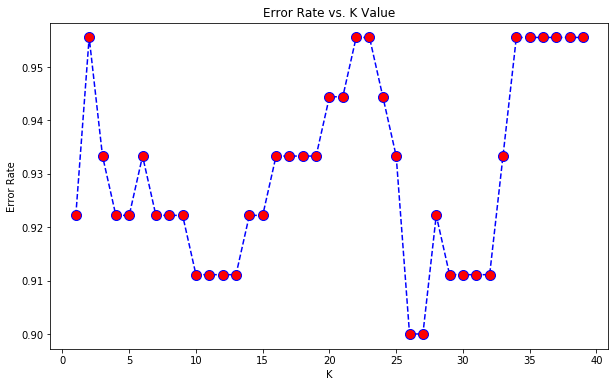

In [135]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

From the graph above, we could see the lowest error rate is achieved in when k is 26. Let's try to model it by using k = 26:

In [136]:
knn = KNeighborsClassifier(n_neighbors=26)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                     weights='uniform')

### Performance On Training Dataset

In [137]:
knn_training_pred = knn.predict(X_train)
print('MAE:',metrics.mean_absolute_error(y_train, knn_training_pred))
print('MSE:',metrics.mean_squared_error(y_train, knn_training_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, knn_training_pred)))

MAE: 9.8
MSE: 180.83333333333334
RMSE: 13.44742850262954


### Performance On Test Dataset

In [138]:
knn_test_pred = knn.predict(X_test)
print('MAE:',metrics.mean_absolute_error(y_test, knn_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, knn_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, knn_test_pred)))

MAE: 8.5
MSE: 142.83333333333334
RMSE: 11.951290027998372


By using optimum k value, we could see that the performance on the test dataset is improve, while noise is no longer has big influence in the result.

## Random Forest Tuning With Grid Search

In [31]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [92]:
X = df.drop('Math', axis=1)
y = df['Math']

In [93]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)

For this model, we chose max_depth, which is the maximum depth of the tree and n_estimators, the number of trees in the forest as our hyperparameters. For scoring, we chose negative mean absolute error. Closer to zero, the better.

In [34]:
gs = GridSearchCV(
    estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_absolute_error', verbose=0, n_jobs=-1)


In [35]:
grid_result = gs.fit(X_train, y_train)
best_params = grid_result.best_params_

In [36]:
grid_result.best_params_, grid_result.best_score_

({'max_depth': 6, 'n_estimators': 50}, -8.522421654158123)

In [37]:
rf = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=100, verbose=False)

After getting the best parameter, now we are performing K-Fold cross validation which used to determine the model performance.

In [38]:
cv = KFold(n_splits=10, random_state=42, shuffle=False)
scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

In [39]:
print('10 fold CV MAE: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

10 fold CV MAE: -8.487 +/- 1.195


In [40]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=100, verbose=False, warm_start=False)

### Performance On Training Dataset

In [41]:
rf_train_pred = rf.predict(X_train)

In [42]:
print('MAE:',metrics.mean_absolute_error(y_train, rf_train_pred))
print('MSE:',metrics.mean_squared_error(y_train, rf_train_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, rf_train_pred)))

MAE: 6.045366617395545
MSE: 58.11000424696704
RMSE: 7.622991817322582


### Performance On Test Dataset

In [43]:
rf_test_pred = cross_val_predict(rf, X_test, y_test, cv=10)

In [44]:
rf_test_pred = rf.predict(X_test)

In [45]:
print('MAE:',metrics.mean_absolute_error(y_test, rf_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, rf_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, rf_test_pred)))

MAE: 7.332922794195251
MSE: 110.15284515359517
RMSE: 10.495372559065979


With grid search, the performance on test dataset is improving, while the performance gap to the training dataset is slimmer, so we can say that with grid search we could overcome the overfitting problem that occur in previous random forest model.

### Feature Importances

In [47]:
columns = X.columns
train = pd.DataFrame(np.atleast_2d(X_train), columns=columns)

In [48]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances.head(10)

,index,importance
0,Science,0.320577
1,Statistics,0.305358
2,Pysics,0.270977
3,Total_Pass,0.057021
4,Statistics_Pass,0.039500
5,Physics_Pass,0.004012
6,Science_Pass,0.002554


## Gradient Boost Tuning With Grid Search

With gradient boosting, the most crucial parameters are maximum depth, number of estimators, which already we discuss on random forest section, and learning rate. So that we will use those parameters as our hyperparameters. 

In [49]:
clf = GridSearchCV(
    estimator=GradientBoostingRegressor(),
        param_grid={
            'max_depth': range(3,7),
            "learning_rate": [0.01,0.005,0.001],
            'n_estimators': (1250,1500,1750)
        },
        cv=5, scoring='neg_mean_absolute_error', verbose=0, n_jobs=-1)


In [50]:
grid_result = clf.fit(X_train, y_train)
best_params = grid_result.best_params_

In [51]:
grid_result.best_params_, grid_result.best_score_

({'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 1500},
 -8.714752892165638)

In [52]:
clf = GradientBoostingRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], learning_rate=best_params["learning_rate"], random_state=100, verbose=False)

Just like the random forest model, we also do K-fold Cross Validation to check on our model performance:

In [53]:
cv = KFold(n_splits=10, random_state=42, shuffle=False)
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

In [54]:
print('10 fold CV MAE: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

10 fold CV MAE: -8.853 +/- 1.050


In [55]:
clf.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.001, loss='ls',
                          max_depth=6, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=100, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=False,
                          warm_start=False)

### Performance On Training Dataset

In [56]:
clf_train_pred = clf.predict(X_train)

In [57]:
print('MAE:',metrics.mean_absolute_error(y_train, clf_train_pred))
print('MSE:',metrics.mean_squared_error(y_train, clf_train_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, clf_train_pred)))

MAE: 5.359157165616948
MSE: 45.08861021847222
RMSE: 6.714805300116469


### Performance On Test Dataset

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop(['Math'], axis=1))
scaled_features = scaler.transform(df.drop(['Math'], axis=1))
df_trans = pd.DataFrame(scaled_features)
df_trans.head()
X_train, X_test, y_train, y_test = train_test_split(scaled_features, dfd['Math'], test_size = 0.2)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
print('MAE:',metrics.mean_absolute_error(y_test, pred))
print('MSE:',metrics.mean_squared_error(y_test, pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, pred)))

In [58]:
clf_test_pred = clf.predict(X_test)

In [59]:
print('MAE:',metrics.mean_absolute_error(y_test, clf_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, clf_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, clf_test_pred)))

MAE: 7.438189645380584
MSE: 117.01601899705796
RMSE: 10.817394279449093


Just like the random forest model, with grid search, the performance on test dataset is improving. 

# Conclusion

1. The predictor variables (physics,science and statistics score) are not correlated well with the target variables (math score), all of them are scored under 0.3.
2. Linear regression is not a good fit for the dataset because there is lack of linear relationship between the predictor variables and target variables.
3. k-NN model is picked because beside its insensitiveness to outlier and noise, it works well on non-linear data like our dataset because k-NN does not make assumption about the data. 
4. Ensemble methods (random forest and gradient boosting) are picked because of its ability to decrease variance (bagging) and bias(boosting).
5. Before tuning, our random forest model appears to be overfitted which can be conclude that the model is too complex with low bias and high variance.
6. With k = 1, the k-NN model is having a really high variance because the probability to model the noise in the data is really high. After looking the optimum k value, the model performance is improving with lower variance with MAE of 8.5 in the test dataset. However, its performance is not competitive compared to ensemble methods.
7. Grid search, a process of performing hyper parameter tuning in order to determine the optimal values for a given model, is used for model tuning for both ensemble method models.
8. After tuning, the grid search success to lower the variance in the random forest model, by decreasing the gap error in the training and test dataset.
9. Also after tuning, there are improvements in model performance in the test dataset for both ensemble method models, random forest and gradient boosting. The MAE in random forest is improved by 14% to the MAE of 7.33, while the MAE in gradient boosting is improved by 15% to the MAE of 7.43.
10. With the help of K-fold cross validation, in general both of the model give a quite similar model performance. Random forest gives an average negative MAE score of -8.487 +/- 1.195, while gradient boosting gives an average negative MAE score of -8.853 +/- 1.050.
11. Overall, both random forest and gradient boosting perform nearly identical and they both outperform the k-NN model, however for further tuning gradient boosting could outperform random forest as it has more critical parameters and compare to random forest that only reduce error through reducing variance, gradient boosting reduces both bias and variance by adding new trees and many combining models.